# XGBoost Meta-Learner Implementation (Stacking)

This notebook implements a stacking approach using XGBoost as the meta-learner with 5-fold cross-validation.

In [71]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import KFold
import joblib
import os
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge
from utils import calculate_metric
from mlp import MLP
import torch

# Set random seed for reproducibility
np.random.seed(42)

## Load Data

Load train and test predictions from base models, as well as the target labels.

In [65]:
# Load predictions from different models
training_file_name = '../output/train_predictions.xlsx'
test_file_name = '../output/test_predictions.xlsx'


# Load actual labels
DATA_FOLDER = "../data"
TRAIN_FEATURES = DATA_FOLDER + '/train_features2.xlsx'
TRAIN_LABELS = DATA_FOLDER + "/train_labels2.xlsx"
TEST_FEATURES = DATA_FOLDER + "/test_features2.xlsx"
TEST_LABELS = DATA_FOLDER + "/test_labels2.xlsx"

In [66]:
train_predictions_file = pd.ExcelFile(training_file_name)
test_predictions_file = pd.ExcelFile(test_file_name)

train_features = pd.read_excel(TRAIN_FEATURES)
train_labels = pd.read_excel(TRAIN_LABELS)
test_features = pd.read_excel(TEST_FEATURES)
test_labels = pd.read_excel(TEST_LABELS)

In [8]:
# Display shapes
print("Train labels shape:", train_labels.shape)
print("Test labels shape:", test_labels.shape)

Train labels shape: (1293, 1)
Test labels shape: (432, 1)


In [68]:
# Dictionary to store DataFrames from each sheet
training_predictions = pd.DataFrame()
test_predictions = {}
sheet_names = train_predictions_file.sheet_names

# Read each sheet and store in the dictionary
for sheet_name in sheet_names:
    print(f"Reading sheet: {sheet_name}")
    training = pd.read_excel(training_file_name, sheet_name=sheet_name)
    training_predictions[sheet_name] = training.values.ravel()

    test = pd.read_excel(test_file_name, sheet_name=sheet_name)
    test_predictions[sheet_name] = test.values.ravel()

Reading sheet: xgboost
Reading sheet: beta
Reading sheet: catboost
Reading sheet: GANDALF
Reading sheet: ExactGP
Reading sheet: tabpfn
Reading sheet: svm
Reading sheet: svm_pca
Reading sheet: lightgbm
Reading sheet: cubist
Reading sheet: lasso
Reading sheet: elastic_net
Reading sheet: ridge
Reading sheet: resnet
Reading sheet: mlp
Reading sheet: transformer
Reading sheet: random_forest


In [69]:
training_predictions = pd.DataFrame(training_predictions)
test_predictions = pd.DataFrame(test_predictions)

In [70]:
training_predictions.head()

,xgboost,beta,catboost,GANDALF,ExactGP,tabpfn,svm,svm_pca,lightgbm,cubist,lasso,elastic_net,ridge,resnet,mlp,transformer,random_forest
0,0.085138,0.218201,0.082482,0.178676,0.076854,0.081700,0.218129,0.109359,0.085052,0.080213,0.281884,0.229969,0.217985,0.572105,0.342058,0.075974,0.082039
1,0.394110,0.351533,0.347228,0.465785,0.399874,0.470003,0.422974,0.424036,0.379600,0.389655,0.370661,0.331829,0.336134,0.351827,0.465883,0.327425,0.468096
2,0.867797,0.827843,0.831907,0.909777,0.834497,0.904541,0.880605,0.876604,0.842168,0.921703,0.756832,0.776345,0.777667,0.655756,0.278410,0.900559,0.857461
3,0.988295,0.718953,0.994146,1.039946,0.994263,0.953014,0.826827,0.977952,0.999155,0.994565,0.647183,0.763439,0.783678,0.101535,0.253322,0.867680,0.976850
4,1.031795,0.825804,1.010136,1.101790,1.024460,1.003159,0.917263,0.981880,1.022676,1.030725,0.792360,0.878471,0.888151,0.721331,0.632699,0.939004,1.003600


In [77]:

from pathlib import Path
# load mlp model
MLP_PATH = "../output/mlp/best_mlp_model.pth"

mlp_params = {'linear': [68, 18, 43, 30],
 'dropout': 0.36051593533006826,
 'optimizer': {'optimizer': 'Adam',
  'lr': 0.0012567816952842909,
  'weight_decay': 2.0076983019785407e-06},
 'negative_slope': 0.01,
 'activation_name': 'Tanh'}

model = MLP(d_in=train_features.shape[1], d_layers=mlp_params["linear"], dropout=mlp_params["dropout"], d_out=1, activation_name=mlp_params["activation_name"], negative_slope=mlp_params['negative_slope'])
model.load_state_dict(torch.load(Path(MLP_PATH)))

/var/folders/gc/mln0kg89025flmz65rqz4qn40000gn/T/ipykernel_68259/3000692987.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(Path(MLP_PA

<All keys matched successfully>

In [44]:
training_predictions.shape

(1293, 8)

In [43]:
train_labels.shape

(1293, 1)

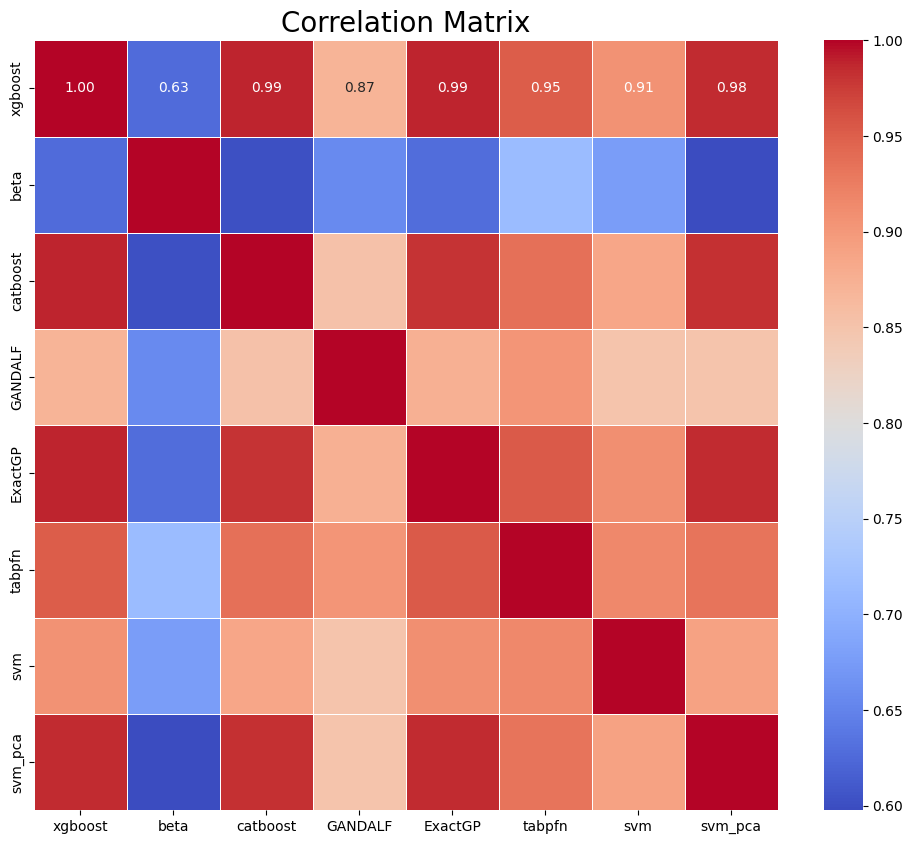

In [49]:
# correlation matrix
correlation_matrix = training_predictions.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, cbar=True)

# Adjustments for aesthetics
plt.title('Correlation Matrix', fontsize=20)
plt.show()

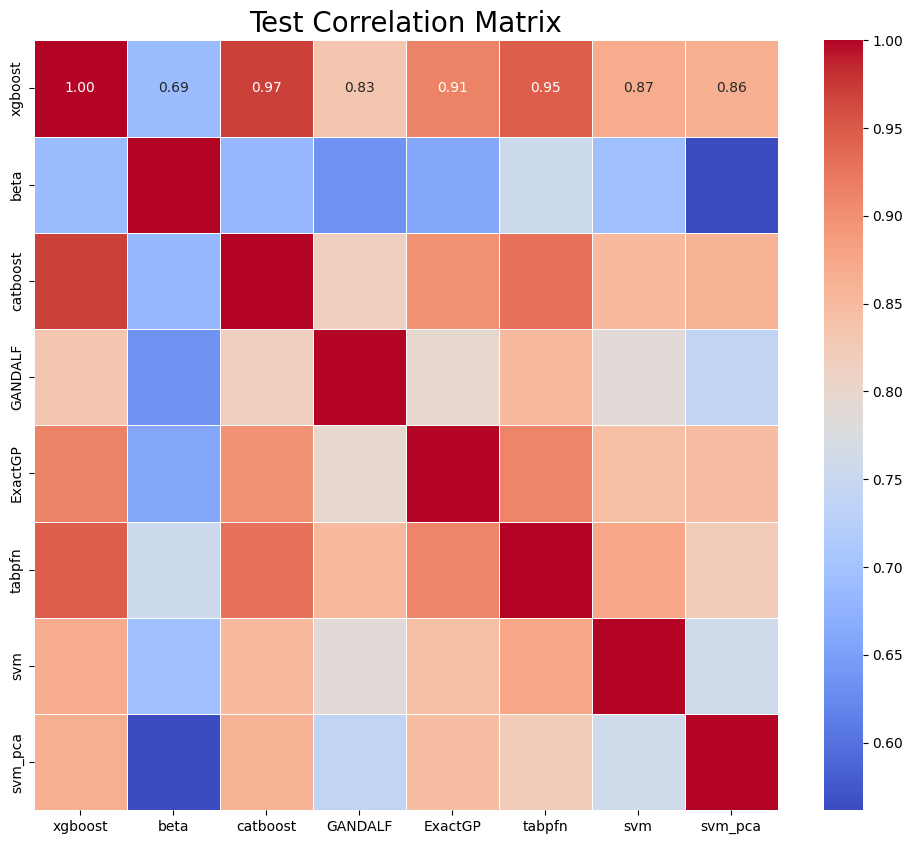

In [52]:
# correlation matrix
correlation_matrix = test_predictions.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, cbar=True)

# Adjustments for aesthetics
plt.title('Test Correlation Matrix', fontsize=20)
plt.show()

In [50]:
meta_model = xgb.XGBRegressor(random_state=42)
meta_model.fit(training_predictions, train_labels)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [51]:
# Make predictions
meta_train_predictions = meta_model.predict(training_predictions)
meta_test_predictions = meta_model.predict(test_predictions)

# Calculate and print metrics
train_metrics = calculate_metric(meta_train_predictions, train_labels.values.ravel())
test_metrics = calculate_metric(meta_test_predictions, test_labels.values.ravel())

print("\nTraining Metrics:")
print(f"MAE: {train_metrics[0]:.4f}")
print(f"MAPE: {train_metrics[1]:.4f}%")
print(f"RMSE: {train_metrics[2]:.4f}")
print(f"R2: {train_metrics[3]:.4f}")

print("\nTest Metrics:")
print(f"MAE: {test_metrics[0]:.4f}")
print(f"MAPE: {test_metrics[1]:.4f}%")
print(f"RMSE: {test_metrics[2]:.4f}")
print(f"R2: {test_metrics[3]:.4f}")


Training Metrics:
MAE: 0.0048
MAPE: 5.4658%
RMSE: 0.0274
R2: 0.9931

Test Metrics:
MAE: 0.1263
MAPE: 334.9378%
RMSE: 0.2217
R2: 0.5711


In [53]:
### Feature importance 

# Create a DataFrame for better visualization
feature_importances = pd.DataFrame({
    'Feature': sheet_names,
    'Importance': meta_model.feature_importances_
})

# Sort the features by importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=True)

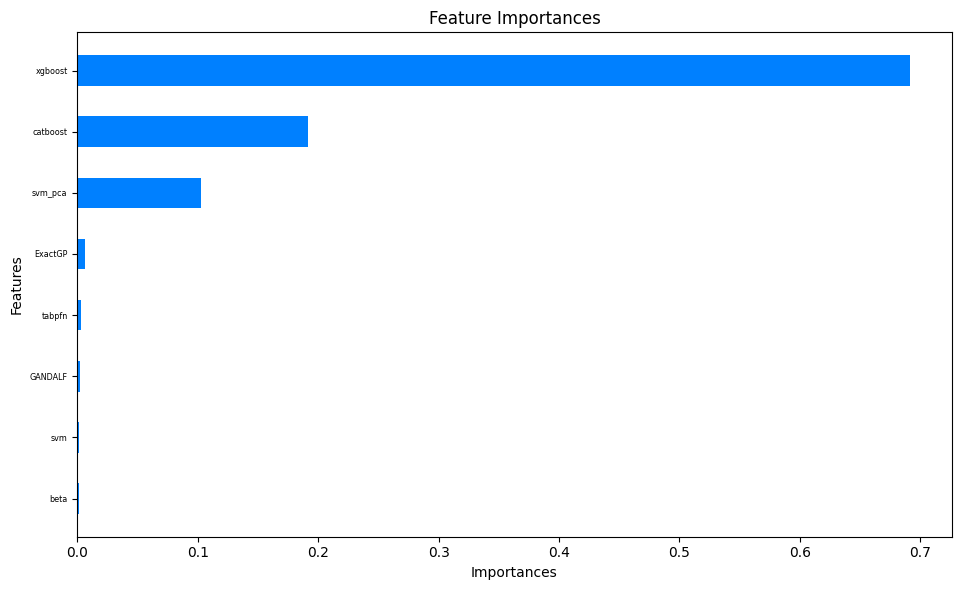

In [54]:
# Create a horizontal bar chart
plt.figure(figsize=(10, 6))  # Adjust the size of the plot as needed
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color=(0, 0.5, 1), height=0.5)  # Adjust the height for spacing

plt.ylabel('Features')  # Label for the y-axis
plt.xlabel('Importances')  # Label for the x-axis
plt.title('Feature Importances')  # Title of the plot
plt.tight_layout()  # Automatically adjust subplot parameters to give specified padding
plt.yticks(fontsize='xx-small')

plt.show()

RIDGE AS META-LEARNER

In [56]:


# Train the final model on the entire training data
ridge_meta_model = Ridge(random_state=42)

ridge_meta_model.fit(training_predictions, train_labels)


Ridge(random_state=42)

In [57]:
# Make predictions
meta_train_predictions = ridge_meta_model.predict(training_predictions)
meta_test_predictions = ridge_meta_model.predict(test_predictions)

# Calculate and print metrics
train_metrics = calculate_metric(meta_train_predictions, train_labels.values.ravel())
test_metrics = calculate_metric(meta_test_predictions, test_labels.values.ravel())

print("\nTraining Metrics:")
print(f"MAE: {train_metrics[0]:.4f}")
print(f"MAPE: {train_metrics[1]:.4f}%")
print(f"RMSE: {train_metrics[2]:.4f}")
print(f"R2: {train_metrics[3]:.4f}")

print("\nTest Metrics:")
print(f"MAE: {test_metrics[0]:.4f}")
print(f"MAPE: {test_metrics[1]:.4f}%")
print(f"RMSE: {test_metrics[2]:.4f}")
print(f"R2: {test_metrics[3]:.4f}")


Training Metrics:
MAE: 0.3735
MAPE: 4662.3324%
RMSE: 0.0495
R2: 0.9774

Test Metrics:
MAE: 0.3594
MAPE: 397.6734%
RMSE: 0.2179
R2: 0.5856


In [62]:
non_zero_coeff = []
non_zero_features = []
coef = ridge_meta_model.coef_
for index, value in enumerate(coef.ravel()):
    if value == 0:
        continue
    non_zero_coeff.append(value)
    non_zero_features.append(sheet_names[index])

In [63]:
### Feature importance 

# Create a DataFrame for better visualization
feature_importances = pd.DataFrame({
    'Feature': non_zero_features,
    'Importance': non_zero_coeff
})

# Sort the features by importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=True)

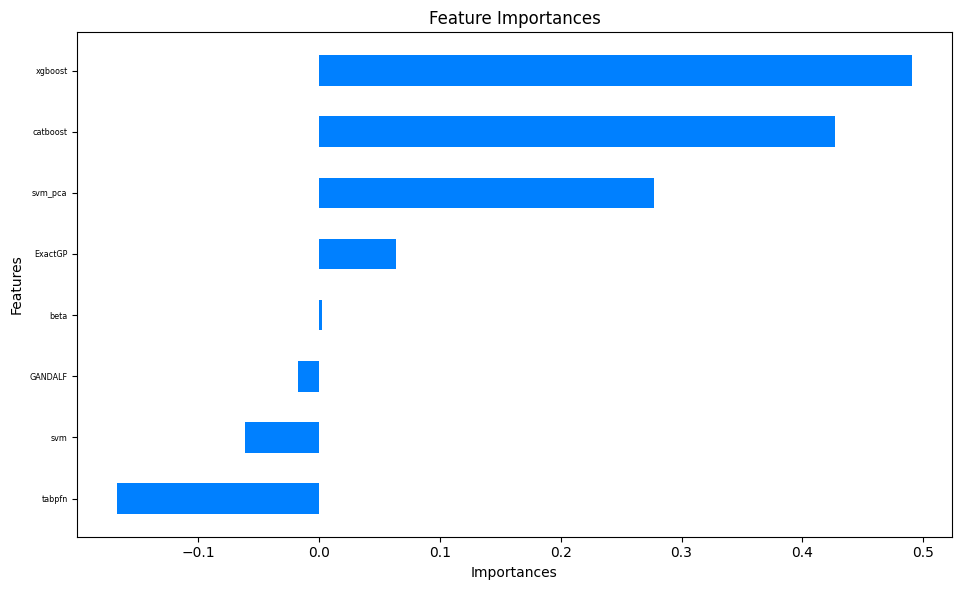

In [64]:
# Create a horizontal bar chart
plt.figure(figsize=(10, 6))  # Adjust the size of the plot as needed
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color=(0, 0.5, 1), height=0.5)  # Adjust the height for spacing

plt.ylabel('Features')  # Label for the y-axis
plt.xlabel('Importances')  # Label for the x-axis
plt.title('Feature Importances')  # Title of the plot
plt.tight_layout()  # Automatically adjust subplot parameters to give specified padding
plt.yticks(fontsize='xx-small')

plt.show()

In [ ]:
# Create a horizontal bar chart
plt.figure(figsize=(10, 6))  # Adjust the size of the plot as needed
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color=(0, 0.5, 1), height=0.4)  # Adjust the height for spacing
# Increase figure height to accommodate the spacing
plt.gcf().set_size_inches(10, max(2, len(feature_importances) * 0.2))

plt.ylabel('Features')  # Label for the y-axis
plt.xlabel('Importances')  # Label for the x-axis
plt.title('Feature Importances')  # Title of the plot
plt.margins(y=0.01) # Include margins adjustment to remove extra whitespace
plt.tight_layout()  # Automatically adjust subplot parameters to give specified padding
plt.yticks(fontsize='xx-small')
plt.savefig(os.path.join(OUTPUT_PATH,'feature_importance.png'))

plt.show()

## Prepare Data for Stacking

Select the models to use for stacking and prepare feature matrices.

In [ ]:
# Extract target values (adjust column index if needed)
y_train = train_labels.iloc[:, 1].values
y_test = test_labels.iloc[:, 1].values

# Get model names from columns (excluding the first column which is usually an ID)
all_models = train_predictions.columns[1:].tolist()
print("\nAvailable models:", all_models)

In [ ]:
# Select models for meta-learning
# You can modify this list to include only the models you want to use
selected_models = [
    'xgboost', 
    'catboost', 
    'ExactGP', 
    'rf',
    'tabpfn'
]

# Filter columns to only include selected models
selected_cols = [col for col in train_predictions.columns if any(model in col for model in selected_models)]
print(f"\nSelected model columns ({len(selected_cols)}):", selected_cols)

In [ ]:
# Create feature matrix from model predictions
X_meta_train = train_predictions[selected_cols].values
X_meta_test = test_predictions[selected_cols].values

print("Meta-training features shape:", X_meta_train.shape)
print("Meta-test features shape:", X_meta_test.shape)

## Implement Stacking with XGBoost and 5-Fold Cross-Validation

In [ ]:
# Create directory for stacking results
os.makedirs('output/stacking_meta_learner', exist_ok=True)

In [ ]:
# Define XGBoost parameters
xgb_params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'learning_rate': 0.05,
    'max_depth': 4,
    'n_estimators': 200,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

In [ ]:
# Implement stacking with 5-fold cross-validation to prevent data leakage
n_folds = 5
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

# Arrays to store cv predictions and test predictions
cv_meta_preds = np.zeros_like(y_train)
test_meta_preds = np.zeros((len(y_test), n_folds))

# For feature importance
feature_importances = np.zeros((len(selected_cols), n_folds))

for fold, (train_idx, val_idx) in enumerate(kf.split(X_meta_train)):
    print(f"Training fold {fold+1}/{n_folds}")
    
    # Split the data
    X_tr, X_val = X_meta_train[train_idx], X_meta_train[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]
    
    # Train XGBoost meta-learner
    meta_model = xgb.XGBRegressor(**xgb_params)
    meta_model.fit(
        X_tr, y_tr,
        eval_set=[(X_val, y_val)],
        early_stopping_rounds=50,
        verbose=100
    )
    
    # Make predictions on validation fold and test set
    cv_meta_preds[val_idx] = meta_model.predict(X_val)
    test_meta_preds[:, fold] = meta_model.predict(X_meta_test)
    
    # Save feature importance for this fold
    feature_importances[:, fold] = meta_model.feature_importances_
    
    # Save the fold model
    joblib.dump(meta_model, f'output/stacking_meta_learner/xgb_meta_model_fold_{fold}.pkl')

In [ ]:
# Average predictions from all folds for the test set
final_test_preds = np.mean(test_meta_preds, axis=1)

In [ ]:
# Train final XGBoost meta-learner on all training data
final_meta_model = xgb.XGBRegressor(**xgb_params)
final_meta_model.fit(
    X_meta_train, y_train,
    eval_set=[(X_meta_train, y_train)],
    early_stopping_rounds=50,
    verbose=100
)
joblib.dump(final_meta_model, 'output/stacking_meta_learner/final_xgb_meta_model.pkl')

## Evaluate Meta-Learner Performance

In [ ]:
# Evaluate cross-validated meta-learner
cv_rmse = np.sqrt(mean_squared_error(y_train, cv_meta_preds))
cv_r2 = r2_score(y_train, cv_meta_preds)
test_rmse = np.sqrt(mean_squared_error(y_test, final_test_preds))
test_r2 = r2_score(y_test, final_test_preds)

print(f"\nMeta-learner (XGBoost Stacking) Performance:")
print(f"Cross-validated Train RMSE: {cv_rmse:.4f}")
print(f"Cross-validated Train R²: {cv_r2:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test R²: {test_r2:.4f}")

## Analyze Feature Importance

In [ ]:
# Average feature importance across folds
avg_importance = np.mean(feature_importances, axis=1)

# Save the importance of each base model in the final meta-learner
importance_df = pd.DataFrame({
    'Model': selected_cols,
    'CV_Importance': avg_importance,
    'Final_Importance': final_meta_model.feature_importances_
})
importance_df = importance_df.sort_values('Final_Importance', ascending=False)
importance_df.to_excel('output/stacking_meta_learner/model_importance.xlsx', index=False)
display(importance_df)

In [ ]:
# Plot feature importance
plt.figure(figsize=(12, 6))
sns.barplot(x='Final_Importance', y='Model', data=importance_df)
plt.title('XGBoost Meta-Learner Feature Importance')
plt.tight_layout()
plt.savefig('output/stacking_meta_learner/feature_importance.png', dpi=300)
plt.show()

## Save Predictions

In [ ]:
# Save predictions
meta_results = pd.DataFrame({
    'ID': train_predictions.iloc[:, 0],  # Assuming first column is ID
    'Actual': y_train,
    'CV_Predicted': cv_meta_preds
})
meta_results.to_excel('output/stacking_meta_learner/train_predictions.xlsx', index=False)
display(meta_results.head())

meta_results_test = pd.DataFrame({
    'ID': test_predictions.iloc[:, 0],  # Assuming first column is ID
    'Actual': y_test,
    'Predicted': final_test_preds
})
meta_results_test.to_excel('output/stacking_meta_learner/test_predictions.xlsx', index=False)
display(meta_results_test.head())

## Visualize Results

In [ ]:
# Calculate residuals
train_residuals = y_train - cv_meta_preds
test_residuals = y_test - final_test_preds

plt.figure(figsize=(12, 5))
plt.